$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{~\middle\vert~}
$$

# CS236781: Deep Learning
# Tutorial 10: Geometric deep learning

## Introduction

In this tutorial, we will cover:

- Filters on graphs
- Graph Laplacians and their meaning
- Graph convolution layers
- Application: semi-supervised node classification

In [1]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'running on: {device}')

running on: cpu


## Theory Reminders: Non-Euclidean domains

So far we have heavily utilized convolutional layers in our deep learning models.

Convolutional layers operate on an input tensor $\vec{x}$ containing $M$ feature maps.
The $j$-th feature map of the output tensor $\vec{y}$ can be written as

$$
\vec{y}^j = \sum_{i=1}^{M} \vec{w}^{ij}\ast\vec{x}^i+b^j,
$$

where $\ast$ denotes convolution, and $x^i$ is the $i$-th input feature map.

Convolutional layers have some important advantages:

- Number of parameters not dependent on the input dimensions.
- Parameters shared across the spatial dimensions of the input.
- Output dimension changes based on input dimension.

### Convolution in the time and frequency domains

Let's dig deeper into convolutions and what they do. Recall the definition of convolution:

$$
\left\{\vec{w}\ast\vec{x}\right\}_j = \sum_{i} w_{j-i} x_{i}.
$$


<center><img src="img/conv.gif" width="1100" /></center>


This is a **linear** operator, which can therefore be represented simply as a matrix multiplication.

Moreover, it's **shift-equivariant** meaning that a shifted input will result in an output shifted by the same amount.
Due to the shift-equivariance, the matrix representing a convolution is always a **Toeplitz** matrix.

<center><img src="img/toeplitz.png" width="400" /></center>

From linear algebra we know that a linear operator can sometimes be **diagonalized** by computing it's **eigendecomposition** (if it exists), and using it's eigenvectors as a basis.

It turns out that **all Topelitz operators** have the same basis (same eigenvectors).

This is the **Fourier** basis,

$$
\phi^{\vec{\xi}}_{\vec{n}} = \exp(j 2\pi \vectr{\xi}\vec{n}),\text{ where } {\vec{n}\in\set{Z}^d}, \vec{\xi}\in[0,1]^d\triangleq\blacksquare,
$$

which is composed of discrete harmonic functions of varying continuous frequency $\vec{\xi}$ sampled in space at $\vec{n}$.

For any Toeplitz operator $\cset{W}$, since we can change matrix-product to convolution we have, 

$$
\begin{align}
\left(\cset{W}\vec{\phi}^\vec{\xi}\right)_\vec{n} =
\left(\vec{w}\ast\vec{\phi}^\vec{\xi}\right)_\vec{n} &=
\sum_{\vec{m}}\vec{w}_\vec{m} \exp(j 2\pi \vectr{\xi}(\vec{n-m})) \\ &=
\exp(j 2\pi \vectr{\xi}\vec{n})\sum_{\vec{m}}\vec{w}_\vec{m} \exp(-j 2\pi \vectr{\xi}\vec{m}) \\ &=
\phi^{\vec{\xi}}_{\vec{n}} \ip{\vec{w}}{\vec{\phi}^{\vec{\xi}}}{\ell^2(\set{Z}^d)} \\ &=
\phi^{\vec{\xi}}_{\vec{n}}\lambda_{\vec{\xi}}.
\end{align}
$$

Thus $\vec{\phi}^{\vec{\xi}}$ is an eigenvector of any Toeplitz operator $\cset{W}$,
with eigenvalue

$$\lambda_{\vec{\xi}}=\hat{w}(\vec{\xi})=\ip{\vec{w}}{\vec{\phi}^{\vec{\xi}}}{\ell^2(\set{Z}^d)}.
$$

We can define the **Fourier transform**  $\cset{F}$ and it's inverse in-terms of inner products with these eigenvectors.

$$
\begin{align}
(\cset{F}\vec{x})(\vec{\xi}) &= \ip{\vec{x}}{\vec{\phi}^{\vec{\xi}}}{\ell^2(\set{Z}^d)}
= \sum_{\vec{n}\in\set{Z}^d} \vec{x}_{\vec{n}}\vec{\phi}^{\vec{-\xi}}_{\vec{n}} = \hat{x}(\vec{\xi}) \\
(\cset{F^{-1}}\hat{x})_\vec{n} &= \ip{\hat{x}}{\vec{\phi}^{\ast}_{\vec{n}}}{L^2(\blacksquare)}
= \int_{\blacksquare} \hat{x}(\vec{\xi})\vec{\phi}^{\vec{\xi}}_{\vec{n}}d\vec{\xi}.
\end{align}
$$

This means we can write any time-domain convolution in terms of frequency-domain product:

$$
\begin{align}
\vec{y} = \vec{w}\ast\vec{x}
&= \cset{W}\vec{x}
= \cset{W} \int_{\blacksquare} \ip{\vec{x}}{\vec{\phi}^{\vec{\xi}}}{}\vec{\phi}^{\vec{\xi}} d\vec{\xi}
= \int_{\blacksquare} \hat{x}(\vec{\xi}) \cset{W} \vec{\phi}^{\vec{\xi}} d\vec{\xi}
= \int_{\blacksquare} \hat{x}(\vec{\xi}) \hat{w}(\vec{\xi}) \vec{\phi}^{\vec{\xi}} d\vec{\xi} \\
&= \ip{\hat{x}\cdot\hat{w}}{\vec{\phi}^{\vec{-\xi}}}{L^2(\blacksquare)} \\
& = \cset{F^{-1}}\left\{\hat{x}\cdot\hat{w}\right\}.
\end{align}
$$

This result is known as the **convolution theorem**.

### Graphs

We will focus our discussion here on Graphs, which are an interesting and useful domain for learning. 
They are also general enough to represent many other non-Euclidean domains,
such as point-clouds and discretized manifolds.

A graph $\cset{G} = (\cset{V},\cset{E}, \mat{A}, \mat{W})$, can be represented with

- A vertex set $\cset{V} = \left\{1,2,\dots,n\right\}$ 
- An edge set $\cset{E}\subseteq \cset{V}\times {V}$
- Vertex-weight matrix $\mat{A}=\mathrm{diag}\left\{a_i\right\}_{i=1}^{n}$.
- Edge-weight matrix $\mat{W}$, where $w_{ij}=0\Rightarrow(i,j)\neq\cset{E}$.


<center><img src="img/random_graph.png" width="800" /></center>

Signals can be defined with the vertices or edges of a graph as their domain.
An appropriate inner-product space can be defined for them.

A **vertex signal** (field) can be defined as a function $f: \cset{V}\rightarrow\set{R}$.

We'll represent these as a vector $\vec{f}\in\set{R}^n$, which can be thought of as a single feature map on the graph.

The inner product for the space of vertex signals is
$
\ip{\vec{f}}{\vec{g}}{\ell^2(\cset{V})}=\sum_{i\in\cset{V}} a_i f_i g_i^\ast .
$

Similarly, an **edge signal** (flow) can be defined as an anti-symmetric function $F:\cset{E}\rightarrow\set{R}$,
which can be represented as a matrix $\mat{F}\in\set{R}^{n\times n}$.

The space of edge signals is equipped with the inner product
$
\ip{\mat{F}}{\mat{G}}{\ell^2(\cset{E})}=\sum_{(i,j)\in\cset{E}} w_{ij} F_{ij} G^\ast_{ij} .
$


#### Graph Laplacian

The graph Laplacian, also known as the Laplace-Beltrami operator is a measure of **smoothness** of a a vertex field, i.e. how quickly it changes between **adjacent** vertices.

More formally, it can be defined as an operator over vertex fields, returning a new vertex field: $\Delta:\ell^2(\cset{V})\rightarrow\ell^2(\cset{V})$.
We can write:

$$
\begin{align}
(\Delta \vec{f})_i = \frac{1}{a_i} \sum_{j\neq i} w_{ij}\left(f_i-f_j\right)
&= \frac{1}{a_i}\left(\left(\sum_{j\neq i} w_{ij}\right) f_i - \sum_{j\neq i}w_{ij}f_j\right) \\
&= \frac{1}{a_i}\left(d_i f_i - \sum_{j\neq i}w_{ij}f_j\right).
\end{align}
$$

Where $d_i$ is the generalized degree of node $i$ (sum of touching-edge weights).

We can thus interpret the Laplacian value at a node as the weighted self-value minus weighted neighbor value, which consolidates the notion of a **smooth** function on a graph.

We can represent this operator as a Laplacian matrix $\mat{\Delta} = \mat{A}^{-1}\left(\mat{D}-\mat{W}\right)\in\set{R}^{n\times n}$, where $\mat{D}$ is a diagonal degree matrix.

#### Eigendecomposition of Graph Laplacian

In the Euclidean domain, the **Laplacian**,
$
\Delta f(\vec{x}) = -\mathrm{div}\nabla f (\vec{x})= - \sum_i \pderiv{{}^2 f}{x_i^2}
$ is a translation equivariant operator and therefore also has a Fourier eigenbasis!

For example, notice that $\Delta e^{jkx} = - \frac{d^2}{dx^2} e^{jkx} = k^2 e^{jkx}.$

Similarly, for a graph domain, we can compute the eigenvectors of the Laplacian matrix (which always has an eigen decomposition), and use them as a basis for representing any vertex function.

We can write the eigendecomposition as

$$
\mat{\Delta}\mat{\Phi} = \mat{\Phi}\mat{\Lambda}
$$

where as usual $\mat{\Phi}$ contains the eigenvectors of $\mat{\Delta}$ in its columns and $\mat{\Lambda}$ is a diagonal matrix of eigenvalues.
Note that $\mat{\Phi}$ is $\mat{A}$-orthonormal, i.e. $\mattr{\Phi}\mat{A}\mat{\Phi}=\mat{I}$.

The eigenfunctions of the laplacian form the smoothest-possible basis function over a specific graph (they minimize the Dirichlet energy).

<img src="img/laplacian_eigenfunctions.png" width="1400" />

Since the Laplacian eigenvectors form a basis for the space $\ell^2(\cset{V})$,
we can represent any vertex field as a linear combination of them:

$$
\vec{f}=\sum_k \hat{f}_k\vec{\phi}_k = \sum_k \ip{\vec{f}}{\vec{\phi}_k}{\ell^2(\cset{V})} \vec{\phi}_k.
$$

We can thus define the **graph-specific** Fourier basis as these eigenvectors.

The Fourier transforms for a graph function is then,
$$
\begin{align}
(\cset{F}\vec{f}) &= \hat{\vec{f}} = \mattr{\Phi}\vec{f} \\
(\cset{F^{-1}}\hat{\vec{f}}) &= \vec{f} = \mat{\Phi}\hat{\vec{f}}.
\end{align}
$$

### Spectral convolution layer for graphs

In the Euclidean case, we have seen that applying a linear filter amounts to time-domain convolution or freq-domain product.

$$
\cset{W}\vec{f} = \vec{w}\ast\vec{f}
= \cset{F^{-1}}\left\{\hat{f}\cdot\hat{w}\right\}
= \cset{F^{-1}}\left\{(\cset{F}f)\cdot\hat{w}\right\}.
$$

This result was obtained by directly using the definition of the convolution operator and the Fourier basis.

In a non-euclidean domain, the notion of translation (shift) is undefined, so we can't easily define convolution.

However, we can **define** $\cset{W}f \triangleq \cset{F^{-1}}\left\{\hat{f}\cdot\hat{w}\right\}$, skipping the time-domain convolution, and plug in the domain-specific definition of the Fourier transform based on the graph Laplacian:

$$
\cset{W}f = \cset{F^{-1}}\left\{\hat{f}\cdot\hat{w}\right\}
= \sum_k \hat{f}_k \hat{w}_k \vec{\phi}_k
= \sum_k \ip{\vec{f}}{\vec{\phi}_k}{} \hat{w}_k \vec{\phi}_k
= \mat{\Phi}\mat{\hat W}\mattr{\Phi}\vec{f},
$$

where $\mat{\hat W}$ is a diagonal matrix representing the filter parameters.

Based on this method for applying a filter on a graph function, we can define our Spectral CNN layer.

- Input: vector-valued vertex field
  $\mat{X} = (\vec{x}^1, \dots, \vec{x}^m),\ \vec{x}^i\in\ell^2({\cset{V}})$.
  Each vertex has $m$ associated features, i.e. our graph has $m$ feature maps.
- Output: vector-valued vertex field
  $\mat{Y} = (\vec{y}^1, \dots, \vec{y}^{m'}),\ \vec{y}^i\in\ell^2({\cset{V}})$.
  
Thus,

$$
\vec{y}^j = \varphi\left( \sum_{i=1}^{m} \mat{\Phi}\mat{\hat{W}}^{ij}\mattr{\Phi}\vec{x}^i + b^j \right).
$$

Unfortunately, this type of graph convolution layer suffers from severely inhibiting **drawbacks**.

- Number of learned parameter depends on domain size $n$ and is not fixed.
- Degree of freedom per eigenvector: potential to create very high frequency (non-smooth) filters. Recall that smoothness in frequency equates to spatial-localization.
- Need to compute both directions of the Fourier transform, each time with $\cset{O}(n^2)$ cost.
- Learned filters are domain-dependent and will not generalize well (i.e. to a different graph).

<img src="img/spectral_generalization.png" width="1000"/>


Left: a signal $f$ on a manifold $\cset{X}$.

Middle: a spectral edge-detection filter, represented as $\mat{W}$, is applied to $f$.

Right: The same filter applied to the same function but on a different domain $\cset{Y}$, which is an isometry of $\cset{X}$. This causes the filter to produce completely different results.

### Spatial convolution layer for graphs

To overcome the drawbacks imposed by the Spectral CNN layer, we will first limit our learned parameters to be smooth interpolations of the Laplacian eigenvalues.

This will simultaneously address the first two drawbacks listed above.


We'll define our learned filter parameters as $\hat{\mat W}^{ij}=\mathrm{diag}\{\mat{B}\vec{\alpha}^{ij}\}$, where

$$
\begin{pmatrix}
\hat{w}^{ij}_1\\
\vdots\\
\hat{w}^{ij}_n\\
\end{pmatrix}
=
\begin{pmatrix}
\beta_1(\lambda_1) & \cdots & \beta_q(\lambda_1) \\
\vdots & \ddots & \vdots \\
\beta_1(\lambda_n) & \cdots & \beta_q(\lambda_n) \\
\end{pmatrix}
\begin{pmatrix}
\alpha^{ij}_1\\
\vdots\\
\alpha^{ij}_q\\
\end{pmatrix}.
$$

The $\beta_i(\lambda)$'s are smooth functions such as polynomials.

The number of parameters no longer depends on domain size. The use of interpolation helps ensure we get smooth spectral coefficients for our filter.

How many parameters do we have in our layer now?

$q\cdot m \cdot m'$. No dependence on $n$.

The second improvement comes from discarding the Fourier transform.
If we select $\beta_k(\lambda)=\lambda^k$, then our spatial filter is

$$
\begin{align}
\mat{W} = \mat{\Phi}\mat{\hat W}\mattr{\Phi}
&= 
\mat{\Phi}
\begin{pmatrix}
\sum_{k=1}^{q}\alpha_k\lambda_1^k &  &  \\
 & \ddots &  \\
 &  & \sum_{k=1}^{q}\alpha_k\lambda_n^k \\
\end{pmatrix}
\mattr{\Phi}
=
\sum_{k=1}^{q}\alpha_k
\mat{\Phi}
\begin{pmatrix}
\lambda_1^k &  &  \\
 & \ddots &  \\
 &  & \lambda_n^k \\
\end{pmatrix}
\mattr{\Phi} \\
&=  \sum_{k=1}^{q}\alpha_k \mat{\Phi} \mat{\Lambda}^k \mattr{\Phi}
= \sum_{k=1}^{q}\alpha_k \mat{\Delta}^k.
\end{align} 
$$

Finally, this gives us a **spatial** (Fourier-free) graph CNN layer:

$$
\vec{y}^j = \varphi\left( \sum_{i=1}^{m} \sum_{k=1}^{q} \alpha^{ij}_k \mat{\Delta}^k \vec{x}^i + b^j \right).
$$

Note:

- The powers of the Laplacian matrix $\mat{\Delta}^k$ are local in $k$-rings around each node.
- We're no longer relying on the Laplacian eigendecomposition, but applying a filter directly in the spatial domain.
- Time complexity now depends on the graph Laplacian sparsity.

Instead of using a regular polynomial, we can generalize by applying other functions of the Laplacian. This can be written slightly more generally as

$$
\mat{Y}=\varphi\left( \sum_{k=1}^{q} \beta_k(\mat{\Delta}) \mat{X} \mat{\alpha}_k + \vec{b} \right).
$$

Where $\mat{\Delta}$ is the $n\times n$ Laplacian, $\mat{X}$ is an $n\times m$ features matrix, and $\mat{\alpha}_k$ is an $m\times m'$ weight matrix.

## Application: Semi-supervised node classification

We'll now face the problem of classifying nodes in a small social-network graph, where we only have true labels for a tiny subset of the nodes.

The approach is based on [Kipf & Welling (2016)](http://arxiv.org/abs/1609.02907).

### Dataset

We'll use a toy dataset of a small social network represented as a graph, known as "Zachary's Karate Club" (Zachary, W. W., J. Anthr. R., 1977).
The network has two **communities** which we'll try to detect, by classifying each node as belonging to one of them.

From [Wikipedia](https://en.wikipedia.org/wiki/Zachary%27s_karate_club),

> A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972.
> The network captures 34 members of a karate club, documenting links between pairs of members who **interacted outside the club**.
> During the study a conflict arose between the **administrator** "John A" and **instructor** "Mr. Hi" (pseudonyms), which led to the split of the club into two.
> 
> Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split. 
> 

In [3]:
# NetworkX is a very useful graph library for python
import networkx as nx

G = nx.karate_club_graph()
ID_INSTR = 0
ID_ADMIN = 33
ID_MEMBERS = set(G.nodes()) - {ID_ADMIN, ID_INSTR}

print(f'{G.name}: {len(G.nodes)} vertices, {len(G.edges)} edges')

Zachary's Karate Club: 34 vertices, 78 edges


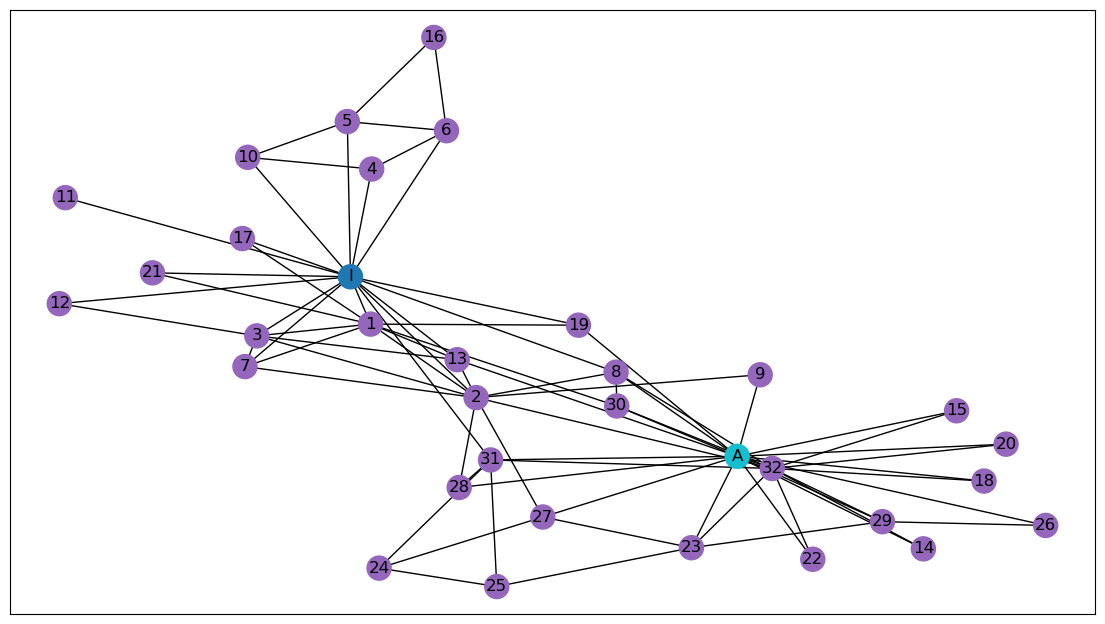

In [4]:
# Visualize the Karate Club graph
fig, ax = plt.subplots(1,1, figsize=(14,8), dpi=100)
pos = nx.spring_layout(G)
cmap = cmap=plt.cm.tab10
node_colors = 0.4*np.ones(G.number_of_nodes())
node_colors[ID_INSTR] = 0.
node_colors[ID_ADMIN] = 1.
node_labels = {i: i for i in ID_MEMBERS}
node_labels.update({i: l for i,l in zip([ID_ADMIN, ID_INSTR],['A','I'])})
nx.draw_networkx(G, pos, node_color=node_colors, labels=node_labels, ax=ax, cmap=cmap);

Since our dataset is a graph, let's also visualize it's spectrum and Fourier basis.

A=
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]
L=
[[16 -1 -1 ... -1  0  0]
 [-1  9 -1 ...  0  0  0]
 [-1 -1 10 ...  0 -1  0]
 ...
 [-1  0  0 ...  6 -1 -1]
 [ 0  0 -1 ... -1 12 -1]
 [ 0  0  0 ... -1 -1 17]]


Text(0.5, 1.0, 'Spectrum')

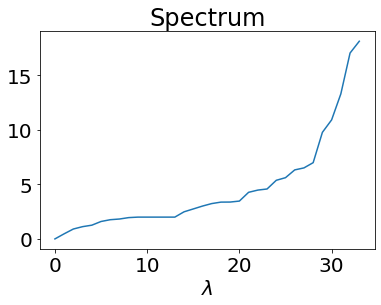

In [5]:
# Adjacency
A = nx.adj_matrix(G, weight=None)
A = np.array(A.todense())
# Degree matrix
dii = np.sum(A, axis=1, keepdims=False)
D = np.diag(dii)
# Laplacian
L = D - A
w, Phi = np.linalg.eigh(L)

# Show matrices & spectrum
print(f'A=\n{A}\nL=\n{L}')
plt.plot(w); plt.xlabel(r'$\lambda$'); plt.title('Spectrum');

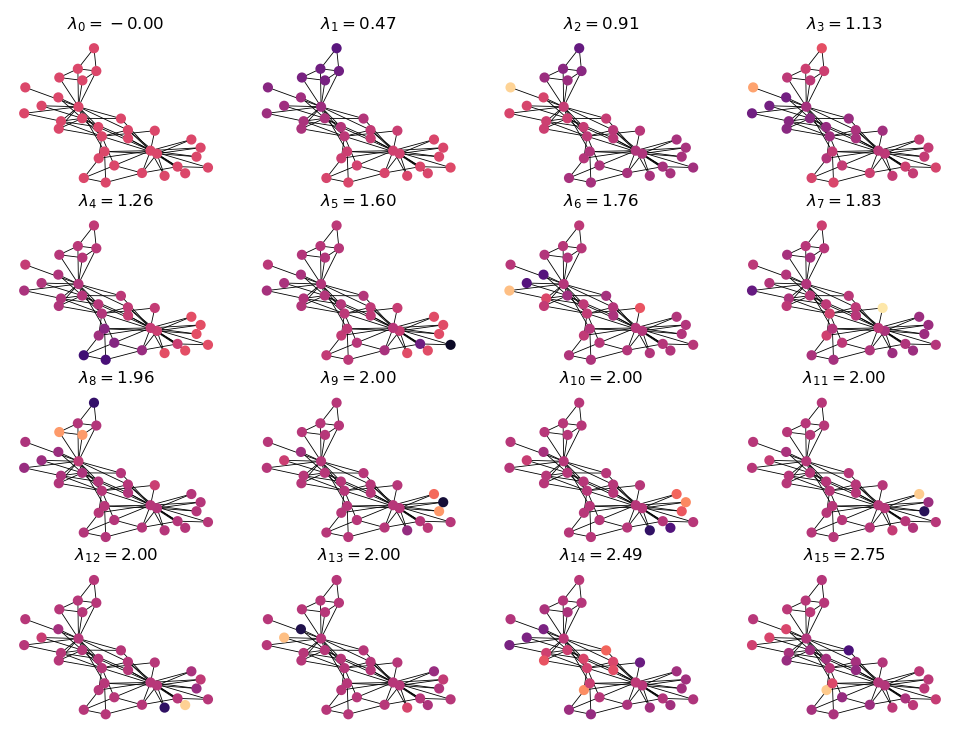

In [6]:
# Plot Fourier basis
fig, ax = plt.subplots(4, 4, figsize=(8,6), dpi=150)
ax = ax.reshape(-1)
vmin, vmax = np.min(Phi), np.max(Phi)
for i in range(len(ax)):
    nc = Phi[:,i]
    nx.draw_networkx(G, pos, node_color=nc, with_labels=False, node_size=15, ax=ax[i], width=0.4, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
    ax[i].axis('off')
    ax[i].set_title(rf'$\lambda_{{{i}}}={w[i]:.2f}$',fontdict=dict(fontsize=8))

#### Features and targets

- Each node in the graph has an extra attribute, `club`, representing the member's post-split affiliation.
- We'll save all the labels for test time, but we'll only train on the Instructor and Administrator data.
- Instead of real features for each node (member) we'll just use a one-hot encoding.
  The purpose is to show that we can classify nodes based on the graph structure alone.

In [7]:
# Input: features will be one-hot vectors (no actual info conveyed)
X = torch.eye(G.number_of_nodes())

# Create ground-truth labels
labels = [(0 if d['club']=='Mr. Hi' else 1) for i,d in G.nodes().data()]
labels = torch.tensor(labels, dtype=torch.long)

# Labels represent group affiliation
list(G.nodes().data())

[(0, {'club': 'Mr. Hi'}),
 (1, {'club': 'Mr. Hi'}),
 (2, {'club': 'Mr. Hi'}),
 (3, {'club': 'Mr. Hi'}),
 (4, {'club': 'Mr. Hi'}),
 (5, {'club': 'Mr. Hi'}),
 (6, {'club': 'Mr. Hi'}),
 (7, {'club': 'Mr. Hi'}),
 (8, {'club': 'Mr. Hi'}),
 (9, {'club': 'Officer'}),
 (10, {'club': 'Mr. Hi'}),
 (11, {'club': 'Mr. Hi'}),
 (12, {'club': 'Mr. Hi'}),
 (13, {'club': 'Mr. Hi'}),
 (14, {'club': 'Officer'}),
 (15, {'club': 'Officer'}),
 (16, {'club': 'Mr. Hi'}),
 (17, {'club': 'Mr. Hi'}),
 (18, {'club': 'Officer'}),
 (19, {'club': 'Mr. Hi'}),
 (20, {'club': 'Officer'}),
 (21, {'club': 'Mr. Hi'}),
 (22, {'club': 'Officer'}),
 (23, {'club': 'Officer'}),
 (24, {'club': 'Officer'}),
 (25, {'club': 'Officer'}),
 (26, {'club': 'Officer'}),
 (27, {'club': 'Officer'}),
 (28, {'club': 'Officer'}),
 (29, {'club': 'Officer'}),
 (30, {'club': 'Officer'}),
 (31, {'club': 'Officer'}),
 (32, {'club': 'Officer'}),
 (33, {'club': 'Officer'})]

#### Graph laplacian

We'll calculate a modified version of the normalized graph Laplacian based on the paper,

$$
\mat{\Delta} = \mat{D}^{-1/2}\tilde{\mat{A}}\mat{D}^{-1/2}.
$$

Where $\tilde{\mat{A}}=\mat{A}+\mat{I}$, $\mat{A}$ is the adjacency matrix and $\mat{D}=\mathrm{diag}(\{\sum_{i} \tilde{A}_{i,j}\})$ is the degree matrix.

This normalized Laplacian is employed because it has eigenvalues in $[0, 1]$, thus representing a stable linear operator.

Note that,

$$
\Delta_{ij} = \frac{\tilde{A}_{ij}}{\sqrt{D_{ii} D_{jj}}}.
$$

Specifically, $\tilde{\mat{A}}$ represents a graph with self-loops.

**What's the significance of self-loops in this model?**

This allows the output features of a node to depend on it's input features, not just on it's neighbors.

At layer $l$, the model is:

$$
\mat{Z}^{[l]} = \varphi( \mat{\Delta} \mat{Z}^{[l-1]} \mat{W}^{[l]} ),
$$

Where $\mat{Z}^{[l-1]}\in\set{R}^{n\times m}$ and $\mat{W}^{[l]}\in\set{R}^{m\times m'}$.

**What do each of these matrix operations represent?**

- $\mat{\Delta} \mat{Z}^{[l-1]}$ is **combining** values in each feature map, locally: from each node and it's neighbors.
- $\mat{W}^{[l]}$ is **transforming** the combined features from all feature maps into an output feature map.

In [8]:
# Adjacency matrix
A = nx.adj_matrix(G, weight=None)
A = np.array(A.todense())
I = np.eye(A.shape[0])
A = A + I

# Degree matrix
dii = np.sum(A, axis=1, keepdims=False)
D = np.diag(dii)

# Normalized Laplacian
D_inv_h = np.diag(dii**(-0.5))
L = np.matmul(D_inv_h, np.matmul(A, D_inv_h))

### Model

We'll implement our graph convolutional network (GCN) directly based on the **spatial** formula shown above.

I.e., we'll compute simple powers of the Laplacian matrix to locally combine node features.

Our model will have two GCN layers.
Each layer takes a tensor containing $C_\text{in}$ features for each node,
and returns a tensor containing $C_\text{out}$ features.

<center><img src="img/gcn.png" width="1200" /></center>


Recall, our spatial GCN definition was

$$
\mat{Y}=\varphi\left( \sum_{k=1}^{q} \beta_k(\mat{\Delta}) \mat{X} \mat{\alpha}_k + \vec{b} \right).
$$

Where $\mat{\Delta}$ is the $n\times n$ Laplacian, $\mat{X}$ is an $n\times m$ features matrix, and $\mat{\alpha}_k$ is an $m\times m'$ weight matrix.

We'll implement this, with the simple case of $\beta_k(\lambda)=\lambda^k$.


In [9]:
import torch.nn as nn

class GCNLayer(nn.Module):
    def __init__(self, graph_L, in_features, out_features, max_deg=1):
        super().__init__()
        
        self.fc_layers = []
        for i in range(max_deg):
            # Each FC is like the alpha_k matrix, with the last one including bias
            fc = nn.Linear(in_features, out_features, bias=(i==max_deg-1))
            self.add_module(f'fc_{i}', fc)
            self.fc_layers.append(fc)
        
        # Pre-calculate beta_k(L)
        self.laplacians = self.calc_laplacian_functions(graph_L, max_deg)
        
    def calc_laplacian_functions(self, L, max_deg):
        res = [L]
        for _ in range(max_deg-1):
            res.append(torch.mm(res[-1], L))
        return res
        
    def forward(self, X):
        Z = torch.tensor(0.)
        for k, fc in enumerate(self.fc_layers):
            L = self.laplacians[k]
            LX = torch.mm(L, X)
            Z = fc(LX) + Z
        
        return torch.relu(Z)

In [10]:
torch.manual_seed(4)

in_features, out_features = X.shape[1], 2
graph_L = torch.tensor(L, dtype=torch.float)
max_deg = 2
hidden_dim = 10

# Stack two GCN layers as our model
gcn2 = nn.Sequential(
    GCNLayer(graph_L, in_features, hidden_dim, max_deg),
    GCNLayer(graph_L, hidden_dim, out_features, max_deg),
    nn.LogSoftmax(dim=1)
)
gcn2

Sequential(
  (0): GCNLayer(
    (fc_0): Linear(in_features=34, out_features=10, bias=False)
    (fc_1): Linear(in_features=34, out_features=10, bias=True)
  )
  (1): GCNLayer(
    (fc_0): Linear(in_features=10, out_features=2, bias=False)
    (fc_1): Linear(in_features=10, out_features=2, bias=True)
  )
  (2): LogSoftmax(dim=1)
)

### Training

We'll train as a simple classification task, with the only nuance that only the Instructor and Administrator labels are used.

In [11]:
import torch.nn.functional as F
import torch.optim

def train_node_classifier(model, optimizer, X, y, epochs=60, print_every=10):
    y_pred_epochs = []
    for epoch in range(epochs+1):
        y_pred = model(X)
        y_pred_epochs.append(y_pred.detach())

        # Semi-supervised: only use labels of the Instructor and Admin nodes
        labelled_idx = [ID_ADMIN, ID_INSTR]
        loss = F.nll_loss(y_pred[labelled_idx], y[labelled_idx])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            print(f'Epoch {epoch:2d}, loss={loss.item():.5f}')
    return y_pred_epochs

In [12]:
optimizer = torch.optim.Adam(gcn2.parameters(), lr=0.01)

y_pred_epochs = train_node_classifier(gcn2, optimizer, X, labels)

Epoch  0, loss=0.70683
Epoch 10, loss=0.42088
Epoch 20, loss=0.17294
Epoch 30, loss=0.04735
Epoch 40, loss=0.01424
Epoch 50, loss=0.00629
Epoch 60, loss=0.00385


Since our loss is calculated based on two samples only, it's not a good criterion of overall classification accuracy.

Let's look at the the accuracy over all nodes:

In [13]:
from sklearn.metrics import classification_report

y_pred = torch.argmax(gcn2(X), dim=1).numpy()
y = labels.numpy()
print(classification_report(y, y_pred, target_names=['I','A']))

              precision    recall  f1-score   support

           I       1.00      0.94      0.97        17
           A       0.94      1.00      0.97        17

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34



### Compare with MLP

That seemed too easy, so lets see what we get when we use a regular MLP on the same task.

Remember, we're only training using 2/34 labeled samples.

In [14]:
mlp = nn.Sequential(
    nn.Linear(in_features, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, out_features),
    nn.ReLU(),
    nn.LogSoftmax(dim=1)
)

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
_ = train_node_classifier(mlp, optimizer, X, labels, epochs=2000, print_every=500)

print(classification_report(labels.numpy(), torch.argmax(mlp(X), dim=1).numpy(), target_names=['I','A']))

Epoch  0, loss=0.68034
Epoch 500, loss=0.03073
Epoch 1000, loss=0.01061
Epoch 1500, loss=0.00536
Epoch 2000, loss=0.00318
              precision    recall  f1-score   support

           I       0.64      0.41      0.50        17
           A       0.57      0.76      0.65        17

    accuracy                           0.59        34
   macro avg       0.60      0.59      0.57        34
weighted avg       0.60      0.59      0.58        34



As expected the MLP can't learn anything about the nodes that we didn't train on.

Why was the GCN able to do this?

Recall that due to the multiplication with the Laplacian, the node embeddings calculated by the GCN at each layer combine the previous layer features from neighboring nodes.

When we back-propped from our two labeled nodes, we also updated the model parameters to produce more meaningful embedding for their neighbors!

### Visualization

In [15]:
import matplotlib.animation as animation
from IPython.display import HTML

def animate_classification(G, y_pred_epochs):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
    
    def draw(epoch_idx):
        pos = {}
        colors, sizes = [],[]
        for v in range(G.number_of_nodes()):
            pos[v] = y_pred_epochs[epoch_idx][v].numpy()
            y_pred_v = np.argmax(pos[v])
            y_v = labels[v]
            if y_pred_v == y_v: colors.append(y_v)
            else: colors.append(0.4) # wrong prediction
            sizes.append((math.exp(pos[v][y_v]))*300) # size is proba of correct label
        ax.cla()
        ax.set_title(f'Epoch {epoch_idx}')
        nx.draw_networkx(G, pos, node_color=colors, labels=node_labels, ax=ax, cmap=cmap, node_size=sizes, width=0.4)

    anim = animation.FuncAnimation(fig, draw, frames=len(y_pred_epochs), interval=150)
    html = HTML(anim.to_html5_video())
    plt.close()
    return html

In [16]:
animate_classification(G, y_pred_epochs)

**Image credits**

Some images in this tutorial were taken and/or adapted from:

- Kipf T, Welling M. Semi-Supervised Classification with Graph Convolutional Networks (2016).
- Bronstein M. M., et al. (2017) Geometric Deep Learning: Going beyond Euclidean data. IEEE Signal Process Mag 34(4).